C:\Users\KIIT\AppData\Local\Temp\ipykernel_13176\1605075374.py:22: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, line_start - p) / np.linalg.norm(line_end - line_start))


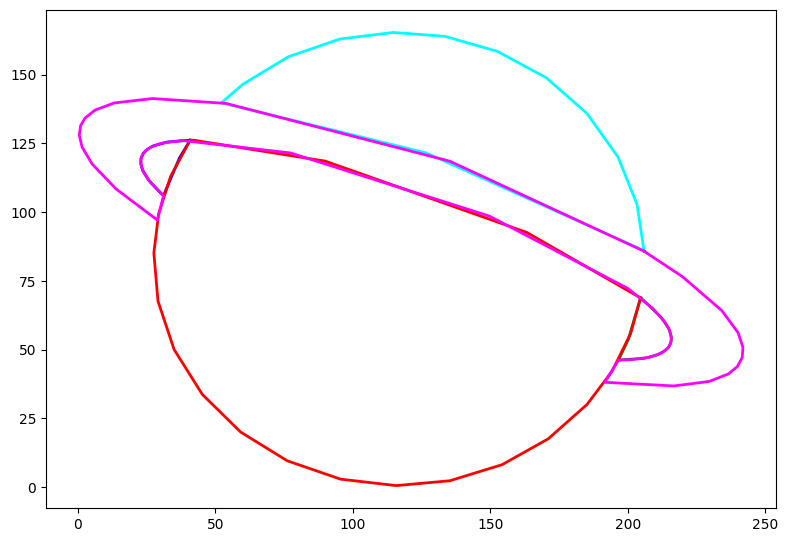

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def simplify_path(XY, tolerance=0.1):
    def distance_point_to_line(p, line_start, line_end):
        if np.allclose(line_start, line_end):
            return np.linalg.norm(p - line_start)
        return np.abs(np.cross(line_end - line_start, line_start - p) / np.linalg.norm(line_end - line_start))

    simplified_XY = [XY[0]]
    for i in range(1, len(XY) - 1):
        if distance_point_to_line(XY[i], simplified_XY[-1], XY[i + 1]) > tolerance:
            simplified_XY.append(XY[i])
    simplified_XY.append(XY[-1])
    
    # Filter out lines inside the circle by checking the relative distance
    simplified_XY = [pt for pt in simplified_XY if not (0.3 < pt[0] < 0.7 and 0.3 < pt[1] < 0.7)]
    return np.array(simplified_XY)

def simplify_paths(paths_XYs, tolerance=0.1):
    simplified_paths_XYs = []
    for XYs in paths_XYs:
        simplified_XYs = []
        for XY in XYs:
            simplified_XYs.append(simplify_path(XY, tolerance))
        simplified_paths_XYs.append(simplified_XYs)
    return simplified_paths_XYs

def plot(paths_XYs):
    colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill='none', stroke=c, stroke_width=2))
    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path,
                     parent_width=W, parent_height=H,
                     output_width=fact * W, output_height=fact * H,
                     background_color='white')

csv_path = 'input/occlusion2.csv'  # Replace with your CSV path
paths_XYs = read_csv(csv_path)
simplified_paths_XYs = simplify_paths(paths_XYs, tolerance=0.1)
plot(simplified_paths_XYs)
svg_path = 'input/occlusion2.svg'  # Replace with your SVG output path
polylines2svg(simplified_paths_XYs, svg_path)